Demonstrate the effects of the number of shape functions and impacts to accuracy between each of the methodologies (go from 2 to 6 or 8 shape functions

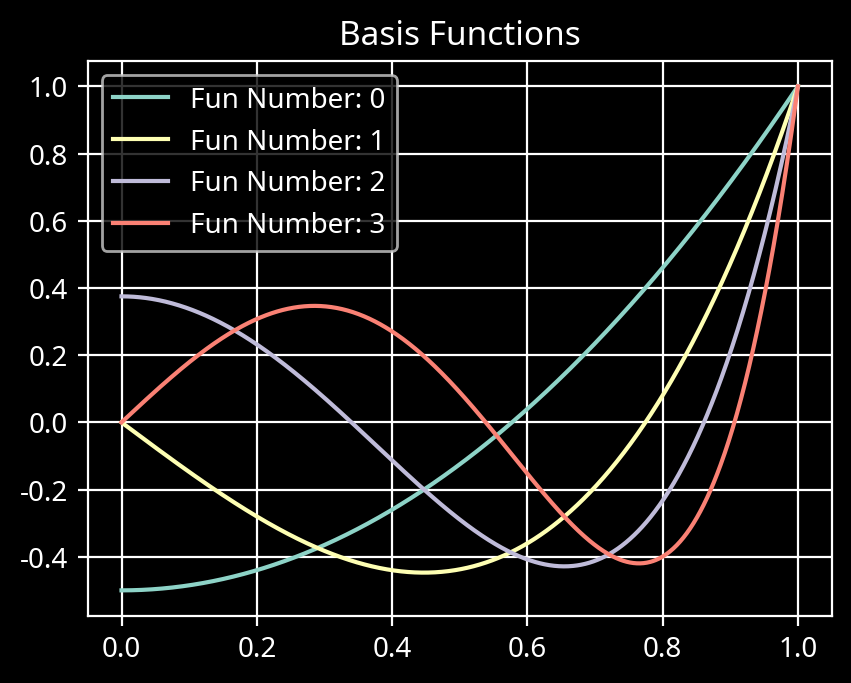

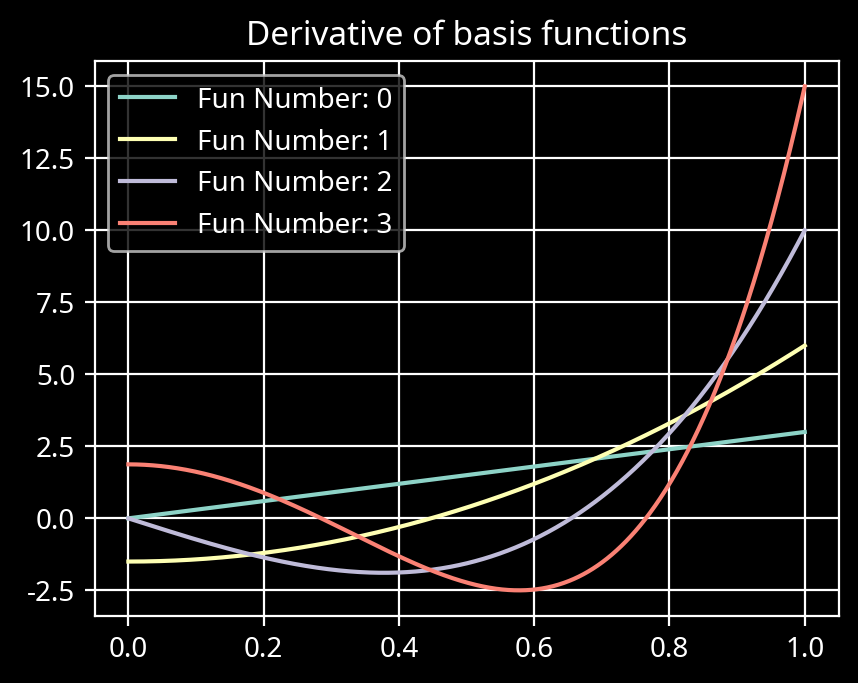

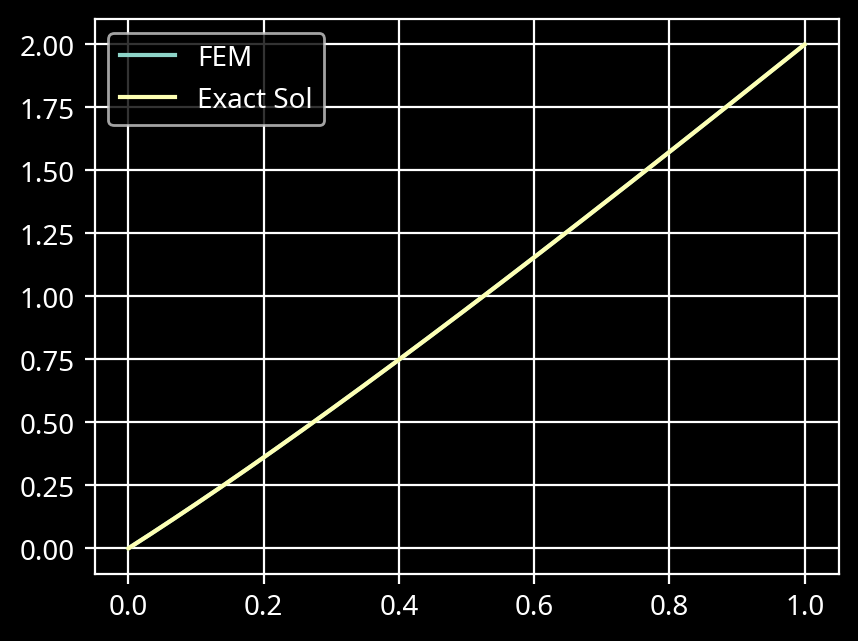

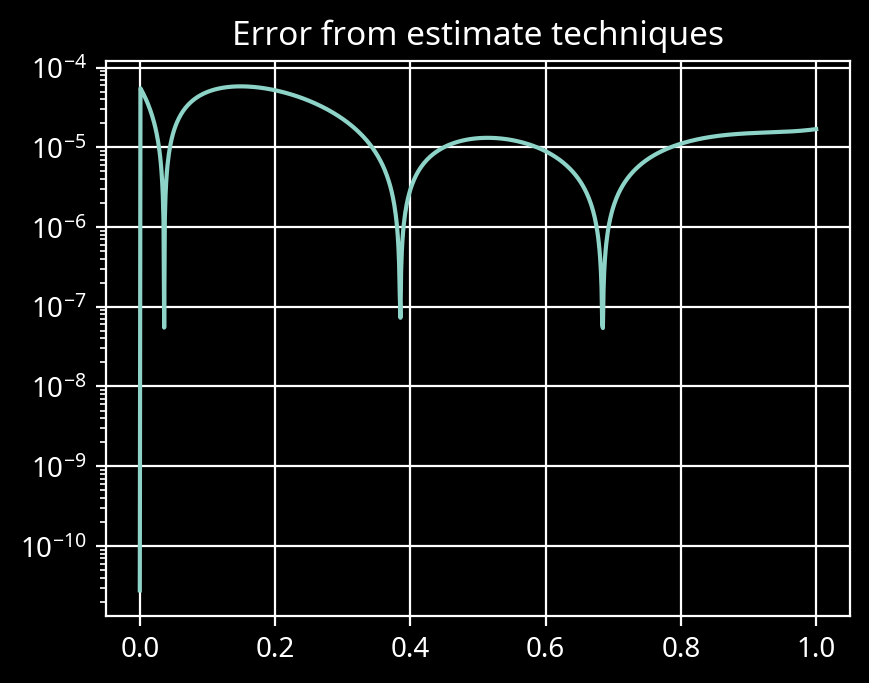

In [1]:
from CurveFits import basisFuns, integrateMatrix, integrateVector, basisFuns2
import numpy as np
import matplotlib.pyplot as plt 

#Most challening part of this problem was the development of the stiffness matrix. Some key notes:
# - Via integration by parts, you have to add terms (K1 & K2) to the stiffness matrix 
# - To account for BC, a function must be assigned for the "homogenous" solution. In this case
#   it was a 0th and 1st order polynomials which drop out after executing derivatives.
# - These additional polynomials must be solved simultaneously with the Galerkin's method terms/coeffs. 

#Model coefficients
#NOTE EXACT SOL REQUIRES THESE TO BE UNCHAGED
a = 1
c1 = 0 #First BC @ 0
c2 = 2 #Second BC @ 1
maxFun = 6

#Creating variables 
x = np.linspace(0,1,1000)

BFun = basisFuns2(2,maxFun) #All functions used in galerkins method 
BFunBC = basisFuns2(0,maxFun) #Functions that include lower order functions (play into BVP terms)
BFun.plot(x)
     
def dKfun(x):
    #Function that defines the ODE 
    (y,dy) = BFun(x)
    return np.matmul(dy.transpose(),dy)*a

def dfFun(x):
    if type(x) == np.ndarray:
        rows = len(x)
    elif type(x) == list:
        rows = len(x) 
    else:
        rows = 1
    y = np.zeros((rows,))
    y[:] = np.exp(-2*x)
    N = BFun.NVals(x)
    return -1*np.matmul(y,N)

def compError(estimate,correct):
    delta = np.abs((estimate - correct)/(correct + 1e-6))
    return delta 

        
#Generating stiffness matrix 
K = np.zeros((BFun.funCount+2, BFun.funCount+2))
K[2:,2:] = integrateMatrix(dKfun,0,1,BFun.funCount)
K[0,:] = BFunBC.NVals(0) #First BC 
K[1,:] = BFunBC.NVals(1) #Second BC
#Building upper bounds matrix
(y,dy) = BFun(1)
K1 = a*np.matmul(y.transpose(),dy) #Upper bounds
#Building lower bounds matrix 
(y,dy) = BFun(0)
K2 = a*np.matmul(y.transpose(),dy) #Lower bounds
K[2:,2:] -= K1-K2 #Applying integration by parts terms 

#Generating force vector 
F = np.zeros((BFun.funCount+2,))
F[2:] = integrateVector(dfFun,0,1,BFun.funCount)
F[0] = c1 
F[1] = c2

#Computing alpha for particular solution
KInv = np.linalg.inv(K)
alpha = np.matmul(KInv,F) 
yFEM = np.matmul(BFunBC.NVals(x),alpha) #Particular solution

#Exact solution
yExact = 0.25*np.exp(-2*x) + 2.2162*x - 0.25

#Plotting overlay 
plt.figure
plt.plot(x,yFEM, label = "FEM")
plt.plot(x,yExact, label = "Exact Sol")
plt.grid("on")
plt.legend()
plt.show()

#Plotting Error terms 
FEMError = compError(yFEM,yExact)
plt.figure
plt.semilogy(x,FEMError)
plt.grid("on")
plt.title("Error from estimate techniques")
plt.show()

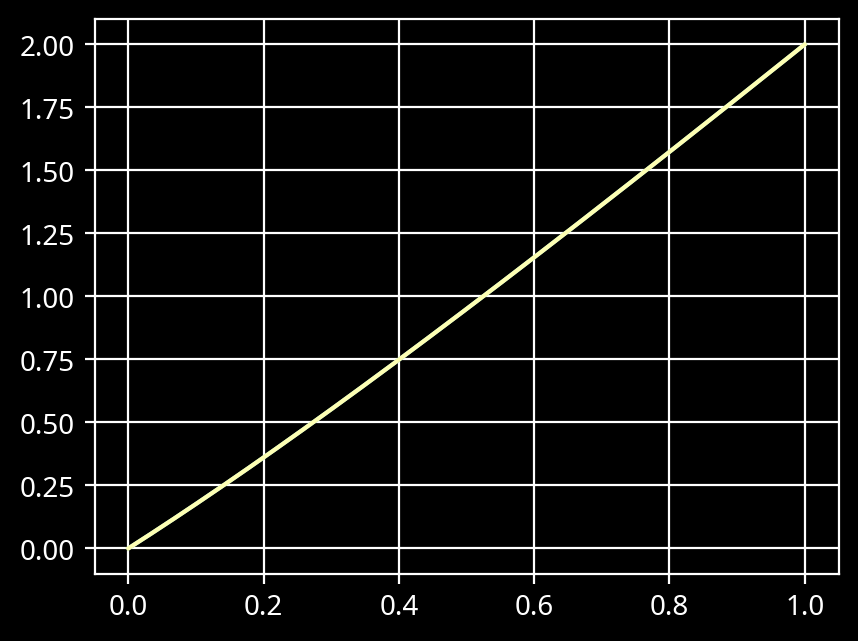

In [2]:
#FDM section
import numpy as np 
import matplotlib.pyplot as plt 

count = 1000
x = np.linspace(0,1,count)
a = 1 
c1 = 0
c2 = 2

dx = x[2]-x[1]
dx2 = dx**2.


K = np.zeros((count,count))
f = np.zeros((count,))
f[:] = np.exp(-2*x)

#Interior points
for i in range(1,(count-1)):
    K[i,i] = a*-2/dx2
    K[i,(i-1)] = a*1/dx2 
    K[i,(i+1)] = a*1/dx2 

#Edge points
K[0,0] = 1 #Left bound edge point
K[-1:,-1:] = 1 #Right bound edge point 
f[0] = c1 #Left bound edge point 
f[-1:] = c2 #Right bound edge point 

yFDM = np.matmul(np.linalg.inv(K),f)

plt.figure
plt.plot(x,yFDM)
plt.plot(x,yExact)
plt.grid("on")


In [3]:
#FVM section 

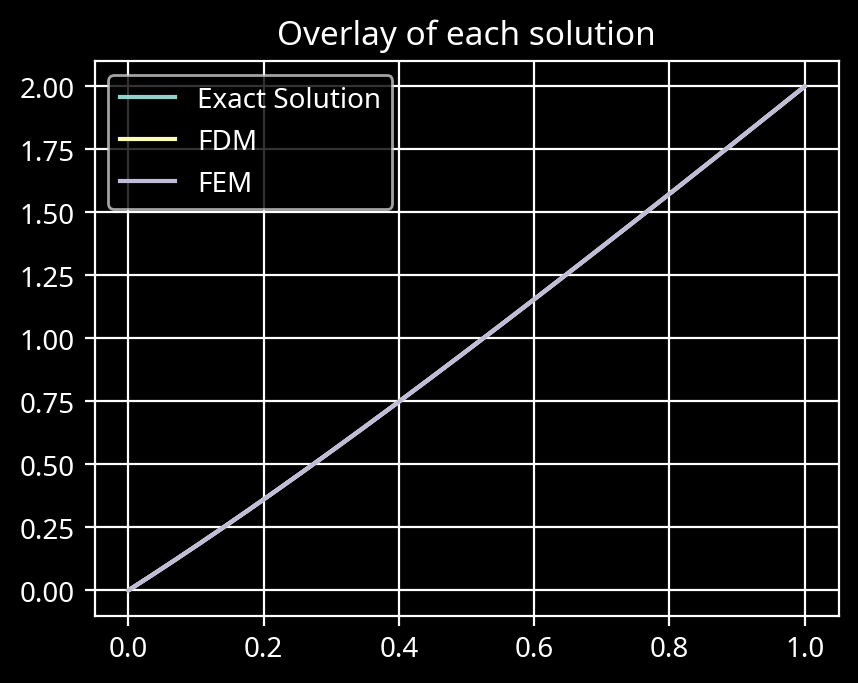

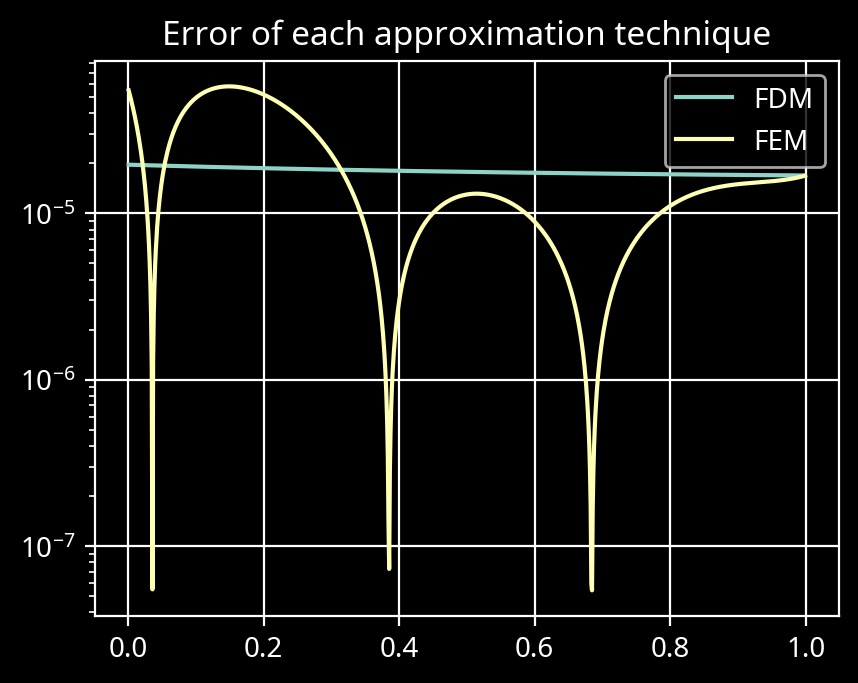

In [4]:
#Plotting all results 

plt.figure
plt.plot(x,yExact, label = "Exact Solution")
plt.plot(x,yFDM, label = "FDM")
plt.plot(x,yFEM, label = "FEM") 
plt.grid("on")
plt.legend()
plt.title("Overlay of each solution")
plt.show() 

plt.figure
plt.semilogy(x[1:-1],compError(yFDM,yExact)[1:-1], label = "FDM")
plt.semilogy(x[1:-1],compError(yFEM,yExact)[1:-1], label = "FEM") 
plt.grid("on")
plt.legend()
plt.title("Error of each approximation technique")
plt.show() 

